In [223]:
from numpy import *
# from matplotlib.pyplot import *
# import os
# ion()

# find hinges
def splitHinge(vals, sites, block):
    # split hinges
    currBlock = 1
    index = 0
    isStart = False
    newSites = []
    newVals = []

    for val in vals:
        if block[index] == currBlock and not isStart:
            isStart = True
            currSites = [sites[index]]
            currValLists = [vals[index]]
        elif block[index] == currBlock and isStart:
            currSites.append(sites[index])
            currValLists.append(vals[index])
        else:
            currBlock += 1
            isStart = True
            newSites.append(currSites)
            newVals.append(currValLists)
            currSites = [sites[index]]
            currValLists = [vals[index]]
        if currBlock == block[-1] and index == len(vals) - 1:
            newSites.append(currSites)
            newVals.append(currValLists)
        index += 1
    # print newSites, newVals
    return newSites, newVals


def mini(a, b):
    if a > b:
        return a
    else:
        return b


def checkIfCrossBase(currVal, currSite, currEigenVec):
    identify = sort(currVal)
    ifRemain = True
    if identify[0] < 0 and identify[-1] > 0:
        ifRemain = True
    else:
        maxSite = max(currSite)
        minSite = min(currSite)
        # print (identify)
        if identify[0] >= 0 and identify[-1] >= 0:
            if currEigenVec[max(0, minSite - 1)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 1)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 2)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 3)] < 0:
                ifRemain = True
            else:
                ifRemain = False
        elif identify[0] <= 0 and identify[-1] <= 0:
            # print (len(currEigenVec))
            # print (currEigenVec[239])

            if currEigenVec[max(0, minSite - 1)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 1))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 2))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 3))] > 0:
                ifRemain = True
            else:
                ifRemain = False

        else:
            print(identify[0], identify[-1])
            print("Check!")
    return ifRemain


def oneModeHinge(currEigenVec, thereshold=20):
    range = ((1 / float(len(currEigenVec))) ** 0.5) / thereshold
    # print (range)
    # print range
    sites = []
    vals = []
    block = []

    index = 0
    blockID = 1
    for item in currEigenVec:
        if item <= range and item >= -range:
            vals.append(item)
            if len(sites) >= 1 and abs(sites[-1] - index) > 1:
                blockID += 1
            sites.append(index)
            block.append(blockID)
        index += 1

    newSites, newVals = splitHinge(vals, sites, block)

    filtSites = []
    filtVals = []

    index = 0
    for item in newSites:
        currSite = newSites[index]
        currVal = newVals[index]
        if checkIfCrossBase(currVal, currSite, currEigenVec):
            filtSites.append(currSite)
            filtVals.append(currVal)
        index += 1

    return filtSites, filtVals


def getValue(currList):
    newList = []
    for item in currList:
        newList.append(float(item))
    return newList


def readModes(fileName):
    allModes = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.strip()
            line = line.split('\t')
            currMode = line[0]
            currVal = line[1:]
            allModes[currMode] = getValue(currVal)
    return allModes


def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def cleanStr(currStr):
    return currStr.strip('\'')

def readFile(fileName):
    data = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.replace('\n', '')
            line = line.strip()
            line = line.split('\t')
            currPDB = line[0]
            currDrug = line[1]
            currChain = line[2:]
            if currPDB not in data.keys():
                data[currPDB] = {}
            if currDrug not in data[currPDB].keys():
                data[currPDB][currDrug] = []
            for each in currChain:
                data[currPDB][currDrug].append(cleanStr(each))
    return data

# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = sqrt(sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = sqrt(sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def writeBinding(fileName, pdb_ids):
    with open(fileName, 'w') as wf:
        for item in pdb_ids:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')


from prody import *
def getModes(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = mean(eigVals, axis=0)

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms, averageEigVects

            
def getDali_info(currPDB, eachChain, rmsd = 2.5, length = 0.9):
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len=length, cutoff_rmsd=rmsd)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of diverse structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    return pdb_ids, mappings

def getHinges(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge


def getHinges_modes(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def get3Hinges_bandwidth(averageEigVects, bandWidths = [15, 16, 17]):
    currHinge = []
    for i in range(3):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidths[i])
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [525]:
def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 5:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif 3 <= len(region) <= 4:
            if values[region[0]-1] * values[region[-1]+1] > 0:
                continue  # Skip this region if adjacent values outside the band have the same sign
   
        elif len(region) == 1:
            region = []
            
        # print ('after filtering',region) 
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg, 15):
            updateRegions.append(currReg)
    
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge



In [510]:
# Experiment to evaluate performance of hypergeometric p values
from scipy.stats import hypergeom
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total


import os
def writeIDs(path, idList):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:

       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")
    
    with open(path + '/ids_diverse.txt', 'w') as wf:
        for item in idList:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')

In [511]:
def writeNumbers(path, numbers):
    with open(path, 'w') as wf:
        for item in numbers:
            wf.write(str(item) + '\n')

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

# Method 3

In [400]:
def trimEnds(values, lists, Number):
    begining = Number
    ends = len(values) - Number
    isInclude = True
    for item in lists:
        if item < begining or item > ends:
            isInclude = False
    return isInclude

def splitRegions(currlist):
    sortList = sort(currlist)
    
    region_list = []
    currRegion = []
    previous = -1
    for item in sortList:
        if item - previous == 1:
            currRegion.append(item)
            previous = item
        else:
            if currRegion != []:
                region_list.append(currRegion)
            currRegion = [item]
            previous = item
    
    if currRegion not in region_list:
        region_list.append(currRegion)
    return region_list
        
def extendRegions(crossovers, values, thereshold):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    return regions


In [401]:
def mergeRegions(lists, max_gap=2, min_length=5):
    merged = [lists[0]]  # Start with the first list

    for next_list in lists[1:]:
        # Check if the next list starts within max_gap+1 of the last element of the current last list in 'merged'
        if next_list[0] - merged[-1][-1] <= max_gap + 1:
            # Merge the lists by extending the last list in 'merged' with the elements of 'next_list'
            merged[-1].extend(next_list)
        else:
            # If it doesn't meet the merge criteria, just append the list as a new one
            merged.append(next_list)

    # Filter merged lists to ensure they meet the min_length requirement after removing duplicates and sort them
    # Keep unmerged lists as they are
    final_list = []
    for sublist in merged:
        unique_sublist = sorted(set(sublist))  # Remove duplicates and sort
        if len(unique_sublist) >= min_length or unique_sublist == sublist:  # Check length or unchanged list
            final_list.append(unique_sublist)
        else:
            # For lists that were attempted to merge but didn't meet the length requirement,
            # revert to individual elements as separate lists
            final_list.extend([[item] for item in unique_sublist])

    # print (final_list)
    finals = []
    for item in final_list:
        if len(item) < min_length:
            finals += splitRegions(item)
        else:
            finals.append(item)
    
    return finals

In [402]:
# Function to trim similar sign values from start
def trim_start(lst, index):
    if len(lst) == 1:
        return lst, index
    if not lst:
        return [], []
    start_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != start_sign:
            return lst[i-1:], index[i-1:]
    return [], []

# Function to trim similar sign values from end
def trim_end(lst, index):
    if len(lst) == 1:
        return lst, index
    
    if not lst:
        return [], []
    lst = lst[::-1]  # Reverse the list for ease of use
    index = index[::-1]
    end_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != end_sign:
            return lst[i-1:][::-1], index[i-1:][::-1]  # Reverse the list again to restore original order
    return [], []

def trimRegions(region, values):
    newRegion = []
    for eachIndex in region:
        currValues = [values[x] for x in eachIndex]
        # print (eachIndex, currValues)
        # Apply the trimming functions
        trimmed_start, trimmed_index = trim_start(currValues, eachIndex)
        # print (trimmed_index)
        trimmed_end, trimmed_index = trim_end(trimmed_start, trimmed_index)
        newRegion.append(trimmed_index)
    return newRegion

In [428]:
def findSmallestPairs(index_list, value_list):
    # Initialize variables to store the smallest sum and corresponding indices
    smallest_sum = float('inf')  # Set it to infinity initially
    smallest_pair = None

    # Iterate through the value list to find adjacent index pairs with the smallest sum of absolute values
    for i in range(len(value_list) - 1):  # -1 because we are looking at pairs
        current_sum = abs(value_list[i]) + abs(value_list[i + 1])
        if current_sum < smallest_sum:
            smallest_sum = current_sum
            smallest_pair = [index_list[i], index_list[i + 1]]
    return smallest_pair

def find_cross_points(Final_test, crossovers, values):
    crossoverPoints_pairs = []
    for item in Final_test:
        if item in crossovers and item - 1 in Final_test:
            crossoverPoints_pairs.append([item - 1, item])
    
    # print ('cross_pairs', crossoverPoints_pairs)
    # filtering_pairs = mergeRegions(crossoverPoints_pairs, max_gap=0, min_length=3)
    # currNumber = len(filtering_pairs) * 2
    if crossoverPoints_pairs == []:
        return []
    
    bestPairs = crossoverPoints_pairs[0]
    bestScore = abs(values[bestPairs[0]]) + abs(values[bestPairs[1]])
    if len(crossoverPoints_pairs) <= 1:
        return bestPairs
    else:
        for item in crossoverPoints_pairs[1:]:
            currScore = abs(values[item[0]]) + abs(values[item[1]])
            # print ('item, score', item, currScore)
            if currScore <= bestScore:
                bestPairs = item
                bestScore = currScore
    
    # print ('filtered', bestPairs)
    return bestPairs


In [429]:
def filteringCriteria(Final, values, crossovers):
    FinalRegions = []
    for region in Final:
        # print ('before filtering', region)
        if len(region) >= 4:
            # print ('region, crossovers, values', region, crossovers)
            allPairs = find_cross_points(region, crossovers, values)
            currRegion = allPairs
            
            # print ('allPairs', allPairs)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            extra = round((len(region) - len(currRegion)) / 2 + 0.00001)
            
            # rest = pos[1:] + neg[1:]
            # restValues = [values[res] for res in rest]
            # combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            rest = []
            for item in region:
                if item not in currRegion:
                    rest.append(item)
            restValues = [values[res] for res in rest]   
            combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            
            # Extract the sorted indexes from the combined list
            sorted_indexes = [index for index, value in combined_list]
            
            region = currRegion + sorted_indexes[:extra]
            # print (region)
            
        # elif 3 <= len(region) == 4:
            # region = find_cross_points(region, crossovers, values)
            # print (region)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        
        # print ('after filtering',region)      
        elif len(region) == 1:
            continue
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    return FinalRegions

In [430]:
def oneModeHinge_update2(values, hinges, thereshold=20):
    # band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    regions = extendRegions(crossovers, values, thereshold)
    # print ('extend Regions', regions)
    
    # merge regions and hinges
    flat = sort(list(set(flattenData(regions) + hinges)))
    Final = splitRegions(flat)
    # print ('before merging', Final)
    Final = mergeRegions(Final, max_gap=2, min_length=5)
    # print ('Final is', Final)
    
    # trim Regions
    # trimmedFinal = trimRegions(Final, values)
    trimmedFinal = Final
    
    # print ('after trimming', trimmedFinal)
    
    FinalRegions = filteringCriteria(trimmedFinal, values, crossovers)
    # print ('after filtering', FinalRegions)
    
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg, 10):
            updateRegions.append(currReg)
    
    # print ('update region is', updateRegions)
        
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

In [426]:
def getHinges_modes3(averageEigVects, mode, hinges, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update2(averageEigVects[:, mode], hinges, thereshold=bandWidth)
    currPos = flattenData(currPos)
    # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges3(averageEigVects, currNumModes, hinges, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update2(averageEigVects[:, i], hinges[i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [489]:
# remove first and last hinges for each chain
def filterTwoEnds(hinges, chainLength = [[0, 551], [552, 956]]):
    FilteringIndex = []
    trimmingLength = 20
    for item in chainLength:
        # print (item)
        FilteringIndex += list(range(item[0], item[0] + trimmingLength))
        FilteringIndex += list(range(item[1] - trimmingLength + 1, item[1] + 1))  
    updateHinges = []
    for item in hinges:
        if item not in FilteringIndex:
            updateHinges.append(item)
    
    return updateHinges

# PDE5A

In [5]:
currPDB = '1udu'
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_A, averageEigVects_A, ids_A, gnms_A, averageEigVects_A = getModes(currPDB, eachChain, length=0.95, rmsd=1, Z=10)


@> Submitted Dali search for PDB "1uduA".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//1uduA/
@> Dali results were fetched in 0.3s.   
@> Obtained 2021 PDB chains from Dali for 1uduA.
@> 1635 PDBs have been filtered out from 2021 Dali hits (remaining: 386).
@> Retrieving 1uduA... [  0%]

# of similar structures is found from Dali 386


@> 386 PDBs were parsed in 107.09s.
@> Mapping 8ufiB_ca to the reference... [  1%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ufiA_ca to the reference... [  1%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsA_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugbB_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsB_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ulgB_ca to the reference... [ 46%] 6s @> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 4htzB_ca to the reference... [ 53%] 5s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 6mzbA_ca to the reference... [ 61%] 4s@> WARNING no atommaps were available. Consider

@> WARNING last 4 modes for 296 modes from MaskedGNM 4mshA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 6ijhA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 1 modes for 296 modes from MaskedGNM 2y0jA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 4 modes for 296 modes from MaskedGNM 2ouyA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 4llxA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 2 modes for 296 modes from MaskedGNM 3wymA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 4 modes for 296 modes from MaskedGNM 4aelA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

@> WARNING last 5 modes for 296 modes from MaskedGNM 6ko1B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 4aelB_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 6ko0B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 4 modes for 296 modes from MaskedGNM 4llpA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 4zo5B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 4 modes for 296 modes from MaskedGNM 7bpiB_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 5dh5B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

@> WARNING last 9 modes for 296 modes from MaskedGNM 6c7dA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 9 modes for 296 modes from MaskedGNM 4d08B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 8 modes for 296 modes from MaskedGNM 5xkmD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 10 modes for 296 modes from MaskedGNM 4jibA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 9 modes for 296 modes from MaskedGNM 6c7eA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 9 modes for 296 modes from MaskedGNM 3ituA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 10 modes for 296 modes from MaskedGNM 5vp1B_ca reduced has been discarded because at least one conformation has only 296 modes
@> W

@> WARNING last 7 modes for 296 modes from MaskedGNM 6blfB_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 7 modes for 296 modes from MaskedGNM 6cybA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 6c7gD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 2 modes for 296 modes from MaskedGNM 5tzzD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 6b96A_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 2 modes for 296 modes from MaskedGNM 6c7eC_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 7 modes for 296 modes from MaskedGNM 6c7iD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

@> WARNING last 7 modes for 296 modes from MaskedGNM 5l9hB_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 5l8cA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 6qguA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 5g2bA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 5l8yA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 6qguB_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 6fdxA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

@> WARNING last 6 modes for 296 modes from MaskedGNM 7l29D_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 7l28A_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 7l27A_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 7kweD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 7l28C_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 7l28D_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 1 modes for 296 modes from MaskedGNM 3v93G_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

In [6]:
currPDB = '1udu'
eachChain = 'B'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_B, averageEigVects_B, ids_B, gnms_B, averageEigVects_B = getModes(currPDB, eachChain, length=0.95, rmsd=1, Z=10)


@> Submitted Dali search for PDB "1uduB".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//1uduB/
@> Dali results were fetched in 0.3s.   
@> Obtained 2063 PDB chains from Dali for 1uduB.
@> 1675 PDBs have been filtered out from 2063 Dali hits (remaining: 388).
@> Retrieving 1uduB... [  0%]

# of similar structures is found from Dali 388


@> 388 PDBs were parsed in 107.24s.
@> Mapping 8ufiB_ca to the reference... [  1%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ufiA_ca to the reference... [  1%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugbB_ca to the reference... [  1%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsA_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsB_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ulgB_ca to the reference... [ 44%] 6s @> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 4htzB_ca to the reference... [ 50%] 5s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 6mzbA_ca to the reference... [ 60%] 4s@> WARNING no atommaps were available. Consider

@> WARNING last 1 modes for 296 modes from MaskedGNM 2y0jA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 4ajdD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 4 modes for 296 modes from MaskedGNM 2ouyA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 2ouuA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 3 modes for 296 modes from MaskedGNM 4ajfA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 4llxA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 4lm4A_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

@> WARNING last 4 modes for 296 modes from MaskedGNM 4ajgD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 6ko0B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 4 modes for 296 modes from MaskedGNM 4mscA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 5dh5B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 3ws9B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 2 modes for 296 modes from MaskedGNM 3wylA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 5xuiB_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

@> WARNING last 9 modes for 296 modes from MaskedGNM 6c7eA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 9 modes for 296 modes from MaskedGNM 5tzaA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 10 modes for 296 modes from MaskedGNM 5vp1B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 9 modes for 296 modes from MaskedGNM 5tzzA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 9 modes for 296 modes from MaskedGNM 4jibA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 9 modes for 296 modes from MaskedGNM 6zqzB_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 9 modes for 296 modes from MaskedGNM 6zqzA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WA

@> WARNING last 6 modes for 296 modes from MaskedGNM 6c7jD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 6b96A_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 2 modes for 296 modes from MaskedGNM 5tzzD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 5xkmF_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 7 modes for 296 modes from MaskedGNM 6blfB_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 7 modes for 296 modes from MaskedGNM 6c7iD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 9 modes for 296 modes from MaskedGNM 5u7lA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

@> WARNING last 5 modes for 296 modes from MaskedGNM 6qguA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 4i15A_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 6fdsB_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 5l8yA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 6fdxA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 5 modes for 296 modes from MaskedGNM 6rgkA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 3 modes for 296 modes from MaskedGNM 4phlA_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

@> WARNING last 6 modes for 296 modes from MaskedGNM 7l29B_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 7l28A_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 7l29D_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 7kweD_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 7l28C_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 6 modes for 296 modes from MaskedGNM 7l28D_ca reduced has been discarded because at least one conformation has only 296 modes
@> WARNING last 4 modes for 296 modes from MaskedGNM 7eg0A_ca reduced has been discarded because at least one conformation has only 296 modes
@> WAR

In [152]:
mergeIDs = []

for item in ids_A:
    for each in ids_B:
        if item[:4] == each[:4] and item[-1] != each[-1]:
            if item[:4] not in mergeIDs:
                mergeIDs.append(item[:4])

mergeIDs.remove('7lrc')
print (mergeIDs)

['1udu', '2h42', '8ufi', '8ugs', '8ugb', '2our', '5b4l', '2oun', '2oup', '2ous', '8di4', '5xuj', '5c28', '3sni', '4fcb', '3sn7', '2ouv', '5axp', '4ajd', '5c1w', '4ajm', '3wym', '4mrw', '4mrz', '4llk', '4llj', '5axq', '2ouq', '4ms0', '4yqh', '4lm4', '3wyk', '7qpm', '4ys7', '4fcd', '5c2a', '4msh', '6ijh', '2y0j', '2ouy', '4llx', '4ael', '4zo5', '4ajg', '5uwf', '4ajf', '4lkq', '4lm3', '6msc', '2ouu', '6kdx', '4msa', '5c2e', '4lm2', '6ke0', '3snl', '4lm0', '6iji', '3wi2', '3ws8', '7qpf', '6kdz', '4lm1', '7qq4', '6msa', '5b4k', '7qpq', '5tzx', '2wey', '4msc', '4msn', '4bbx', '7bpi', '5dh5', '5xui', '3ui7', '3wyl', '4c1i', '4xy2', '5tz3', '5tzh', '4wn1', '3ws9', '7qpv', '5tzw', '5tza', '6c7i', '4mse', '6c7d', '5tzz', '6c7g', '5xkm', '6c7j', '6c7e', '5vp1', '5u7i', '5u00', '5u7d', '6zqz', '5u7k', '5tzc', '4d09', '4jib', '4d08', '3itu', '8ulg', '5u7j', '4htx', '5vp0', '4htz', '6cyd', '6c7f', '6b97', '6cyb', '6cyc', '6b96', '5u7l', '6b98', '6blf', '6mzb', '4y87', '3dy8', '2r8q', '5h2q', '5h2r',

In [10]:
len(mergeIDs)

164

In [165]:
mergeIDs = []

with open('./1udu_diverse/PDE5A_1udu/ids.txt', 'r') as rf:
    for line in rf.readlines():
        line = line.strip()
        line = line.split('\t')
        mergeIDs.append(line[0])
mergeIDs

['6ko0',
 '1udu',
 '5u7d',
 '6ezf',
 '5axq',
 '6msc',
 '6fdx',
 '3snl',
 '6a3n',
 '1ro9',
 '4wn1',
 '1f0j',
 '3ws9',
 '6fdw',
 '6fg5',
 '6b96',
 '1ror',
 '6c7e',
 '5u00',
 '6qgu',
 '6mzb',
 '4lm0',
 '4llk',
 '1z1l',
 '4htz',
 '6rfn',
 '4msc',
 '5k9r',
 '6fds',
 '4ys7',
 '6c7i',
 '5tzh',
 '4bbx',
 '3n3z',
 '6kdx',
 '4y87',
 '3ibj',
 '4lm3',
 '5h2r',
 '4phl',
 '5b4k',
 '4ajm',
 '4zo5',
 '2ouq',
 '5l8y',
 '1t9s',
 '6iji',
 '5uwf',
 '2wey',
 '5xui',
 '1ro6',
 '2h42',
 '6cyd',
 '4lm4',
 '5c2e',
 '3uuo',
 '2ouu',
 '5znl',
 '5c28',
 '6kdz',
 '6msa',
 '6ko1',
 '5g2b',
 '2h44',
 '2ouv',
 '3sni',
 '2oun',
 '5tzx',
 '3gwt',
 '3wyk',
 '5u7i',
 '6fe3',
 '4lm2',
 '2r8q',
 '3ui7',
 '4msh',
 '4ael',
 '6c7j',
 '6c7f',
 '3itm',
 '4d08',
 '6ke0',
 '5h2q',
 '6ezu',
 '6cyc',
 '6frd',
 '5dh5',
 '3wi2',
 '3itu',
 '4ajd',
 '3wyl',
 '6rgk',
 '5xkm',
 '4yqh',
 '6rb6',
 '5tz3',
 '2oup',
 '5tzz',
 '4gh6',
 '5c2h',
 '6ijh',
 '4lkq',
 '4mse',
 '6qgp',
 '3jbq',
 '4xy2',
 '5b4l',
 '5tzw',
 '4ajg',
 '6znd',
 '5xuj',
 

In [166]:
ags = parsePDB(mergeIDs, subset='ca', chain='A B')
dali_ens = buildPDBEnsemble(ags)
gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
eigVals = gnms.getEigvals()
averageEigVals = gnms.getEigvals()[0]
eigVects = gnms.getEigvecs()
averageEigVecs = mean(eigVects, axis=0)

@> Retrieving 5uwfA B... [ 29%] 45s@> WARNING Atomic data could not be parsed, please check the input file.
@> Solving for 3-best solution...rence... [  0%]@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Mapping 6ezfA B_ca to the reference... [  1%]@> WARNING 6ezfA B_ca has fewer chains than 6ko0A B_ca
@> Solving for 3-best solution...rence... [  3%] 48s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  4%] 54s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  8%] 51s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  8%] 52s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  9%] 53s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution.

@> Solving for 3-best solution...rence... [ 75%] 17s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 77%] 16s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 77%] 16s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 79%] 15s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 80%] 15s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 81%] 14s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 82%] 13s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 83%] 13s@> WARNING no atommaps were found. Consider inceasing rmsd_

@> WARNING last 16 modes for 599 modes from MaskedGNM 3wykA B_ca reduced has been discarded because at least one conformation has only 599 modes
@> WARNING last 30 modes for 599 modes from MaskedGNM 4lm2A B_ca reduced has been discarded because at least one conformation has only 599 modes
@> WARNING last 22 modes for 599 modes from MaskedGNM 3ui7A B_ca reduced has been discarded because at least one conformation has only 599 modes
@> WARNING last 30 modes for 599 modes from MaskedGNM 4mshA B_ca reduced has been discarded because at least one conformation has only 599 modes
@> WARNING last 30 modes for 599 modes from MaskedGNM 6ke0A B_ca reduced has been discarded because at least one conformation has only 599 modes
@> WARNING last 30 modes for 599 modes from MaskedGNM 3wi2A B_ca reduced has been discarded because at least one conformation has only 599 modes
@> WARNING last 16 modes for 599 modes from MaskedGNM 3wylA B_ca reduced has been discarded because at least one conformation has 

In [544]:
#remove 216
bindings = ['75', '76', '124', '177', '216','217', '219', '220', '227', '230', '231', '234', '235', '238', '256', '265', '268', '269', '271', '272', '276', '388', '389', '437', '490', '529', '530', '532', '533', '540', '543', '544', '547', '548', '551', '569', '578', '581', '582', '584', '585', '589']
# bindings = ['75', '76', '124', '177', '216', '217', '219', '220', '227', '230', '231', '234', '235', '238', '256', '265', '268', '269', '272', '276', '388', '389', '437', '490', '529', '530', '532', '533', '540', '543', '544', '547', '548', '551', '569', '578', '581', '582', '585', '589']



binding = [int(x) for x in bindings]


In [537]:
sort(binding)

array([ 75,  76, 124, 177, 217, 219, 220, 227, 230, 231, 234, 235, 238,
       256, 265, 268, 269, 271, 272, 276, 388, 389, 437, 490, 529, 530,
       532, 533, 540, 543, 544, 547, 548, 551, 569, 578, 581, 582, 584,
       585, 589])

In [169]:
averageEigVals = gnms.getEigvals()[0]

In [170]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

1

In [171]:
averageEigVects = averageEigVecs

In [538]:
Hinges_2 = getHinges(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges(averageEigVects, 3, 20)

Hinges_4 = getHinges(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges(averageEigVects, 3, 15)


In [539]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 312], [313, 625]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 312], [313, 625]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 312], [313, 625]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 312], [313, 625]])

In [540]:
protein_length = 626

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 41
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 0 0 1
# of hinge sites for first 3 modes, overlap, hyper score 40 8 0.0027205625834441083
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 0 0 1
# of hinge sites for first 3 modes, overlap, hyper score 48 8 0.008958208681496993


In [85]:
ubi = parsePDB('1udu', subset='calpha')
calphas = ubi.select('calpha and chain A B')
gnm = GNM('PDE')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])
Hinge3 = calcHinges(gnm[3])

In [86]:
currNumModes2 = getModesGivenThreshold(gnm.getEigvals(), 0.33)
currNumModes2

1

In [87]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 42
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 3 0 1
# of hinge sites for 3 modes, overlap, hyper score 95 8 0.29647408756869664
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 3 0 1
# of hinge sites for 3 modes, overlap, hyper score 105 8 0.4074224619694792


## writeResults

In [402]:
averageEigVects.shape

(630, 599)

In [445]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)

630

In [446]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum.txt', indices)

In [447]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [448]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 312], [313, 625]])
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [449]:
curr = list(curr)
def writeAllData(path, curr):
    with open(path, 'w') as wf:
        for row in curr:
            for col in row:
                if col == 0.0:
                    wf.write('' + '\t')
                else:
                    wf.write(str(col) + '\t')
            wf.write('\n')
                
writeAllData('./Data/PDE5A_Method1_trim.txt', curr)

## Method 2

In [579]:
currNumModes

1

In [562]:
Hinges_2 = getHinges2(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVects, 3, 20)

Hinges_4 = getHinges2(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVects, 3, 15)


In [563]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 312], [313, 625]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 312], [313, 625]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 312], [313, 625]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 312], [313, 625]])

In [565]:
Hinges_5 = [216 if x == 214 else x for x in Hinges_5]

In [566]:
protein_length = 626

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 42
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 0 0 1
# of hinge sites for first 3 modes, overlap, hyper score 53 8 0.018916722591103774
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 0 0 1
# of hinge sites for first 3 modes, overlap, hyper score 58 9 0.010465733962804147


In [527]:
ORA(42, 626, 53, 9)

0.005627860993427047

In [520]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 42
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 3 0 1
# of hinge sites for 3 modes, overlap, hyper score 100 8 0.3511483698675235
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 3 0 1
# of hinge sites for 3 modes, overlap, hyper score 105 8 0.4074224619694792


In [502]:
# write MSFs
# averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)

630

In [503]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [504]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 312], [313, 625]])
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [505]:
writeAllData('./Data/PDE5A_Method2_trimEnds.txt', curr)

In [568]:
AverageEigVals1 = gnms.getEigvals()[0]
AverageEigVals2 = mean(gnms.getEigvals(), axis=0)
proteinLength = 626
Segment = int(proteinLength / 5)
print ('mark Index are', 0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1)

mark Index are 0 125 250 375 500 625


In [571]:
Labels = ['A:537', 'A:662', 'A:798', 'B:599', 'B:735', 'B:860']
SplitLabel = 313

In [572]:
currHinge = Hinges_5

# of hinges 58
# of bindings sites 42
# of hits are 9


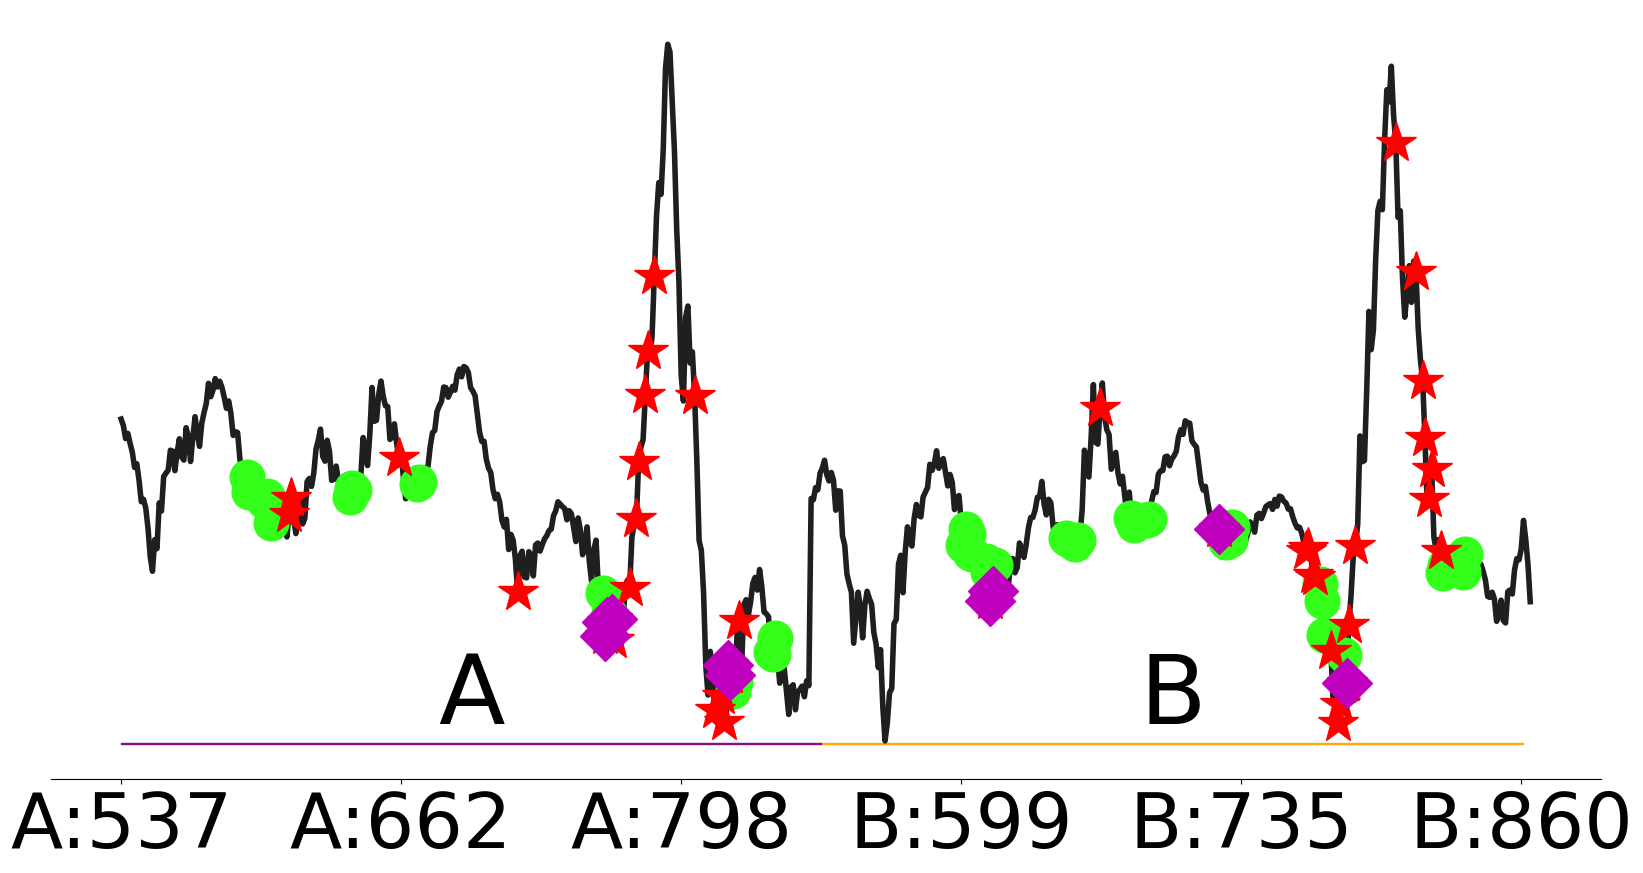

In [588]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
plt.sca(ax)  # Set current axis to 'ax'
    
# Increase font sizes
plt.rc('xtick', labelsize=55)
plt.rc('ytick', labelsize=50)
plt.rcParams.update({'font.size': 70})

# calcMSF
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / AverageEigVals2[mode]
    MSF.append(currMSF)
    
    
# plt.plot(MSF, color='#3B9EFF', linewidth=3, alpha=0.7)
plt.plot(MSF, color='black', linewidth=4, alpha=0.88)

HingeY = [MSF[item] for item in currHinge]
plt.plot(currHinge, HingeY, color=(0.2, 1, 0.1), marker='o', linestyle='', markersize=25)
print ('# of hinges', len(HingeY))

# plot binding sites
bindingY = [MSF[item] for item in binding]
plt.plot(binding, bindingY, 'r*', markersize=30)
print ('# of bindings sites', len(binding))

# plot overlaps
allHinge = currHinge
overlaps = [item for item in binding if item in allHinge]
overlapsY = [MSF[item] for item in overlaps]
plt.plot(overlaps, overlapsY, 'mD', markersize=25)

print ('# of hits are', len(overlaps))

# Hide y labels
plt.gca().yaxis.set_visible(False)

# Hide top, right, and left spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

y = MSF
# Determine the lower y-limit for bands and labels
lower_y_limit = min(y) * 0.1
upper_y_limit = min(y) * 0.5

# Add narrow bands below the plot
ax.add_patch(patches.Rectangle((0, lower_y_limit), SplitLabel, upper_y_limit - lower_y_limit, color='purple', alpha=0.9))
ax.add_patch(patches.Rectangle((SplitLabel, lower_y_limit), proteinLength - SplitLabel, upper_y_limit - lower_y_limit, color='orange',alpha=0.9))
# Add labels just above the bands
ax.text(SplitLabel / 2, upper_y_limit, 'A', color='black', ha='center', va='bottom')
ax.text((SplitLabel + proteinLength) / 2, upper_y_limit, 'B', color='black', ha='center', va='bottom')

# Set x-axis labels and title with Arial font
# plt.title('cGMP-specific 3\', 5\'-cyclic \nPhosphodiesterase')
plt.xticks([0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1], Labels)

plt.savefig('./PDE5A_MSF.png', dpi=500)

In [589]:
AverageEigVals2

array([ 0.12219573,  0.78106165,  0.83283305,  1.01991864,  1.08532891,
        1.36147425,  1.91019318,  3.41802172,  1.94834685,  2.0118613 ,
        2.22507085,  2.49490516,  2.75062424,  3.8011039 ,  3.08495539,
        3.41822125,  3.5705617 ,  3.63091147,  3.55982187,  3.91250818,
        4.72372272,  4.24009127,  4.2701857 ,  4.86811415,  8.97676612,
        5.98236913,  4.62272199,  5.69795678,  4.81051049,  5.39303738,
        5.82420094,  5.83668276,  5.74219005,  6.02668262,  6.52099088,
        7.94187221,  6.57649976,  6.71903009,  7.27238332,  7.85883396,
        9.5684824 ,  7.51637067,  8.52586593,  7.5602886 ,  9.61361795,
        8.26898154,  8.4788637 ,  7.96442041,  8.567845  ,  8.4043901 ,
        8.35026781,  9.11799817,  8.41009875,  8.58080902,  8.67153044,
        8.8008493 ,  9.07074075,  9.44056528,  9.1379053 ,  9.24148927,
        9.86125162,  9.15106998,  9.71823517,  9.76432821,  9.06957708,
       10.47067157, 10.16157503, 11.05888269,  9.5621167 ,  9.72

# method 3

In [407]:
averageEigVects.shape

(630, 599)

In [396]:
ubi = parsePDB('1udu', subset='calpha') # 1udu
calphas = ubi.select('calpha and chain A B')
gnm = GNM('PDE')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])

In [553]:
Hinges_2 = getHinges3(averageEigVects,currNumModes, [Hinge0], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [Hinge0], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 15)

In [475]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 312], [313, 625]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 312], [313, 625]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 312], [313, 625]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 312], [313, 625]])

In [560]:
Hinges_2 = getHinges3(averageEigVects, currNumModes, [[]], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [[], [], []], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [[]], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [[], [], []], 15)

In [561]:
protein_length = 626

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 42
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 2 0 1
# of hinge sites for first 3 modes, overlap, hyper score 61 8 0.04159074291900067
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 2 0 1
# of hinge sites for first 3 modes, overlap, hyper score 64 8 0.053533967407937144


In [473]:
print (sort(Hinges_5))

[ 56  57  64  65  66  67 102 103 104 132 133 172 173 174 212 214 215 216
 217 218 219 271 272 273 274 290 291 292 293 294 335 336 376 377 378 379
 380 386 387 388 389 390 393 400 403 404 422 423 426 427 451 452 458 459
 490 491 493 495 497 517 518 535 536 537 546 547 590 592 593 599 600 608
 609]


## writeResults

In [477]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)

In [478]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [479]:
row, col = averageEigVects.shape

Hinges_calc = [Hinge0, Hinge1, Hinge2]
for mode in modes:
    currHinge = getHinges_modes3(averageEigVects, mode, [], bandWidth=15)
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 312], [313, 625]])
    currList = sort(list(set(list(currHinge))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [480]:
writeAllData('./Data/PDE5A_Method3_0.5_trimEnds.txt', curr)

# Write Modes

In [36]:
def writeModesAsBfactors(mode, eigenVects):
    residue = []
    new_b_factor = []
    chain = 'A'

    resiIndex = 4
    for item in eigenVects[:, mode]:
        resiIndex += 1
        residue.append(resiIndex)
        new_b_factor.append(item)

    with open('./Structure_demo/ALB_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
        for i in range(len(residue)):
            wf.write(chain + ', ' + str(residue[i]) + ', ' + str(new_b_factor[i]) + '\n')

In [37]:
writeModesAsBfactors(0, eigenVects)
writeModesAsBfactors(1, eigenVects)

# Plot graphs

In [104]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


In [550]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3, chain=False)

    # Hinges within band
    # method1
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=20)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currHinge = [216 if x == 214 else x for x in currHinge]
    
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 312], [313, 625]])
    
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', [x + 5 for x in (currHinge)])
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    # Set x-ticks
    # Setting custom tick labels on the x-axis
    plt.xticks([0, 200, 400, 600],['A:537', 'A:748', 'B:624', 'B:835'])
    
    plt.tight_layout()
    plt.savefig('./PDE5A_method2Merging_mode' + str(mode + 1) + '.png', dpi=500)

Hinge residue with wide bands []
local loop motion []
current bindings are [75, 76, 124, 177, 216, 217, 219, 220, 227, 230, 231, 234, 235, 238, 256, 265, 268, 269, 271, 272, 276, 388, 389, 437, 490, 529, 530, 532, 533, 540, 543, 544, 547, 548, 551, 569, 578, 581, 582, 584, 585, 589]
current hits are []
# of overlaps finding from current mode is 0


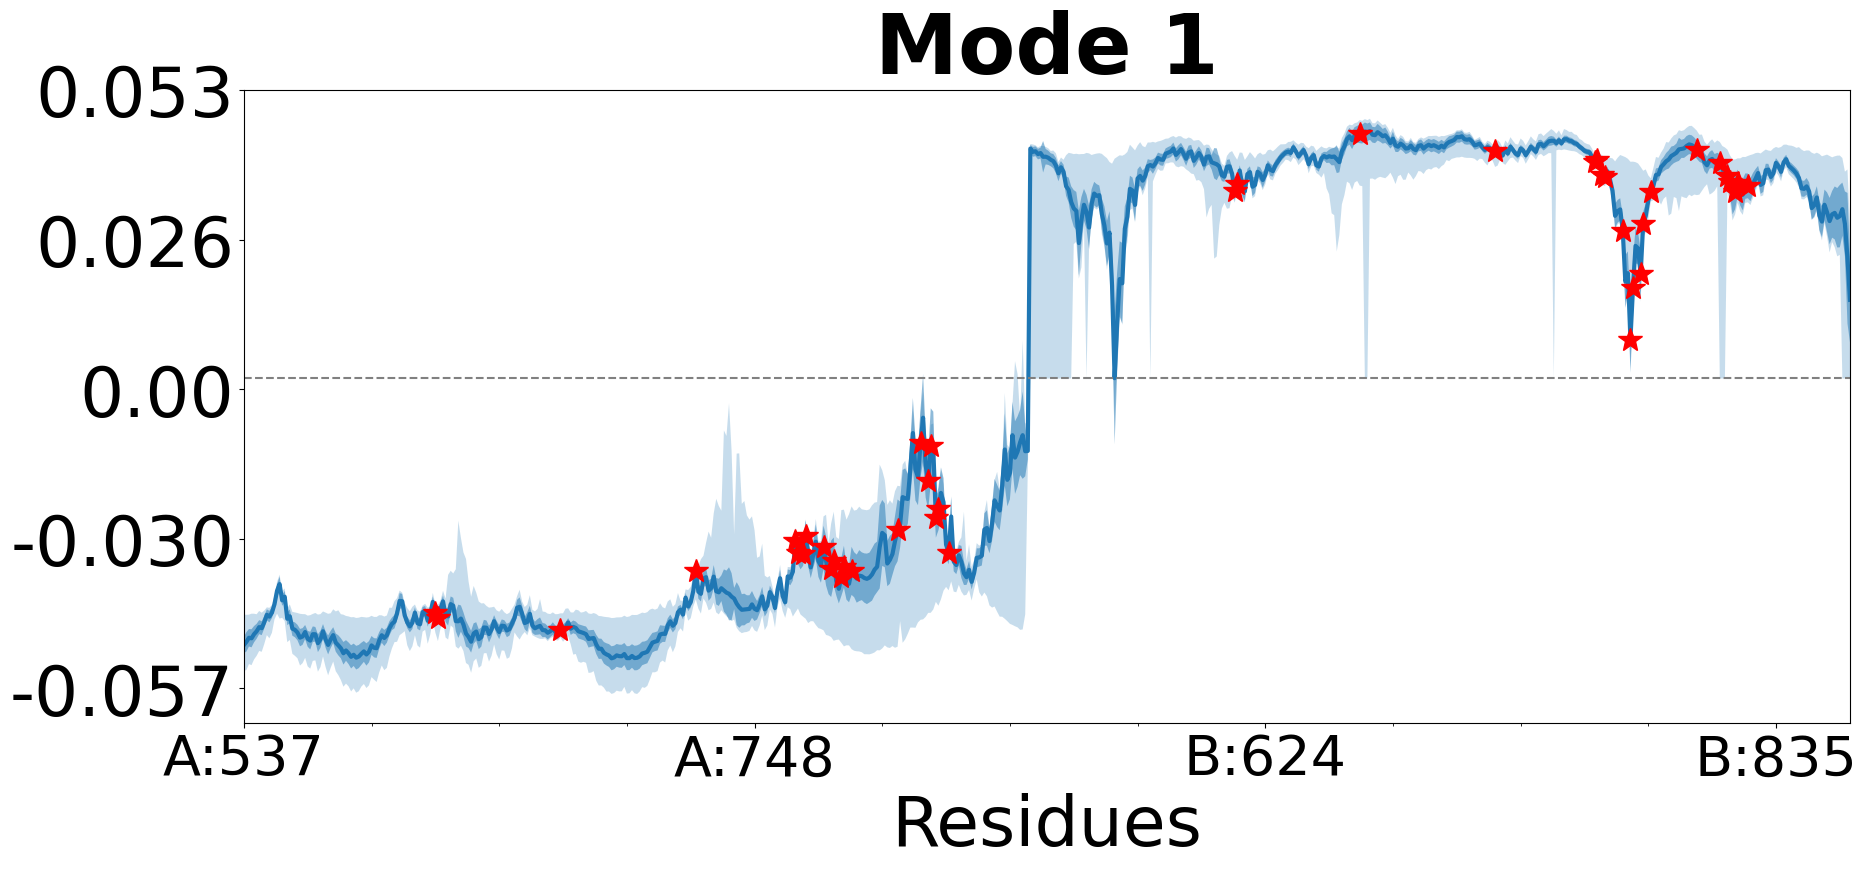

In [551]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [391, 392, 137, 138, 276, 277, 278, 540, 541, 542, 297, 431, 432, 61, 62, 69, 70, 71, 72, 456, 457, 221, 604, 605, 222, 223, 224, 107, 108, 109, 384, 385]
local loop motion []
current bindings are [75, 76, 124, 177, 216, 217, 219, 220, 227, 230, 231, 234, 235, 238, 256, 265, 268, 269, 271, 272, 276, 388, 389, 437, 490, 529, 530, 532, 533, 540, 543, 544, 547, 548, 551, 569, 578, 581, 582, 584, 585, 589]
current hits are [216, 217, 219, 271, 272]
# of overlaps finding from current mode is 5


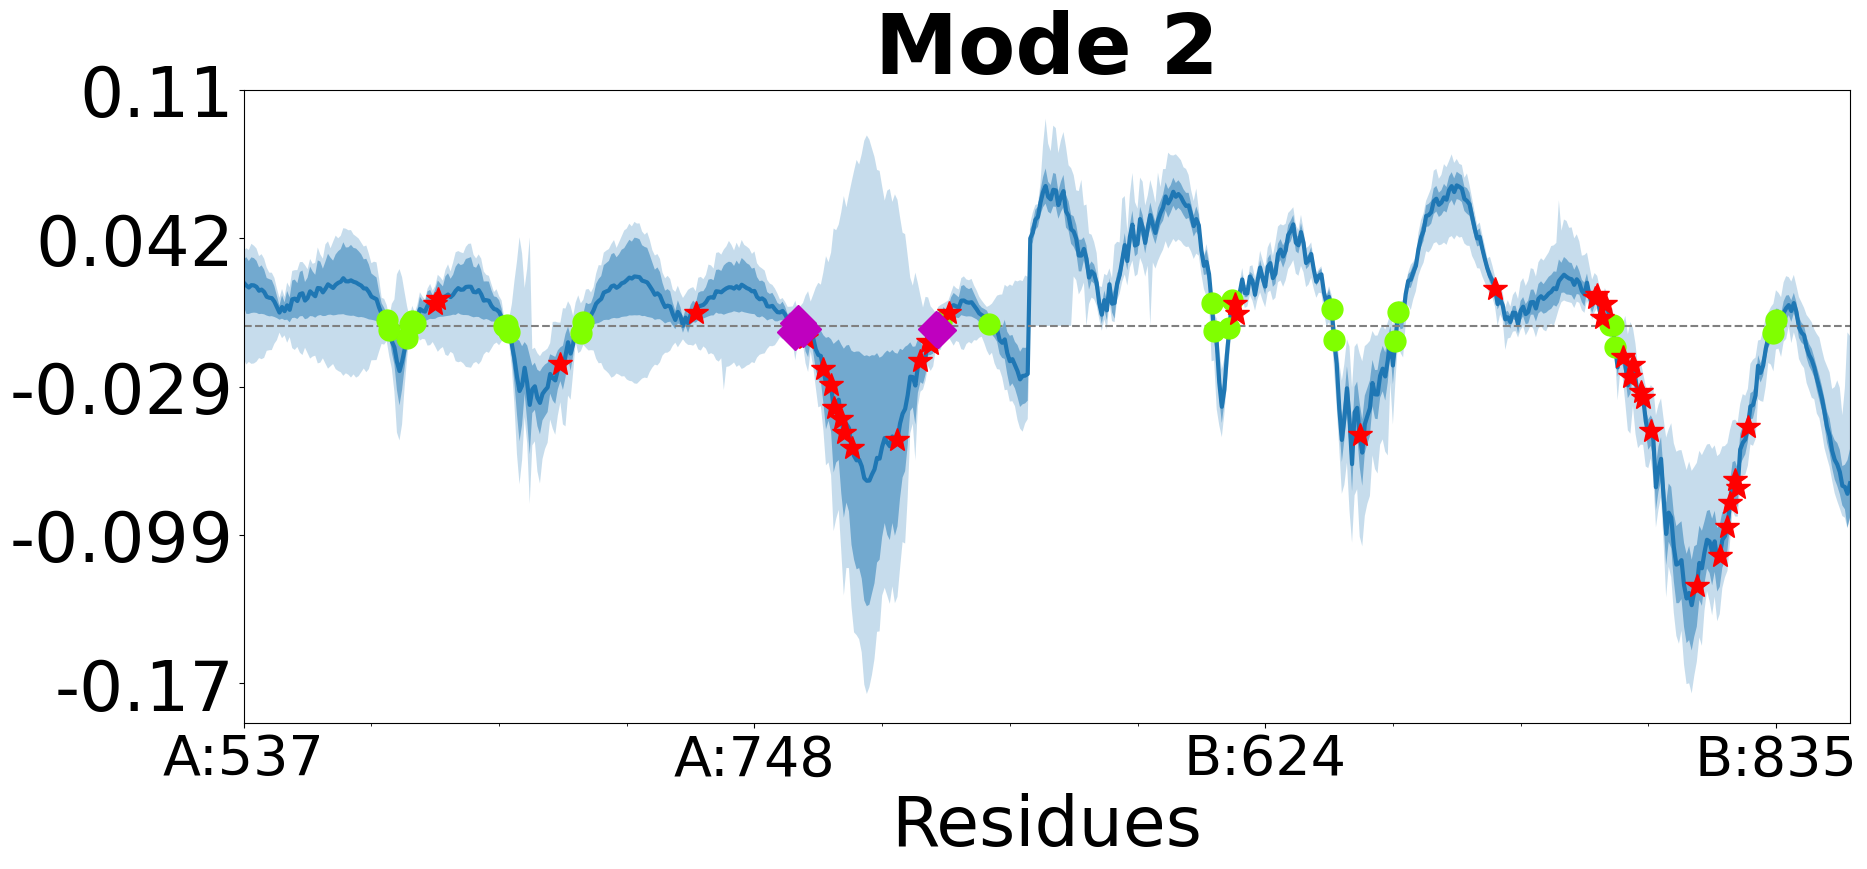

In [552]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [137, 138, 393, 394, 395, 278, 279, 295, 296, 551, 552, 427, 428, 61, 62, 69, 70, 463, 464, 595, 596, 597, 598, 221, 220, 107, 108, 109, 495, 496, 498, 499, 500, 501, 381, 382, 383]
local loop motion []
current bindings are [75, 76, 124, 177, 216, 217, 219, 220, 227, 230, 231, 234, 235, 238, 256, 265, 268, 269, 271, 272, 276, 388, 389, 437, 490, 529, 530, 532, 533, 540, 543, 544, 547, 548, 551, 569, 578, 581, 582, 584, 585, 589]
current hits are [216, 388, 389, 490, 547]
# of overlaps finding from current mode is 5


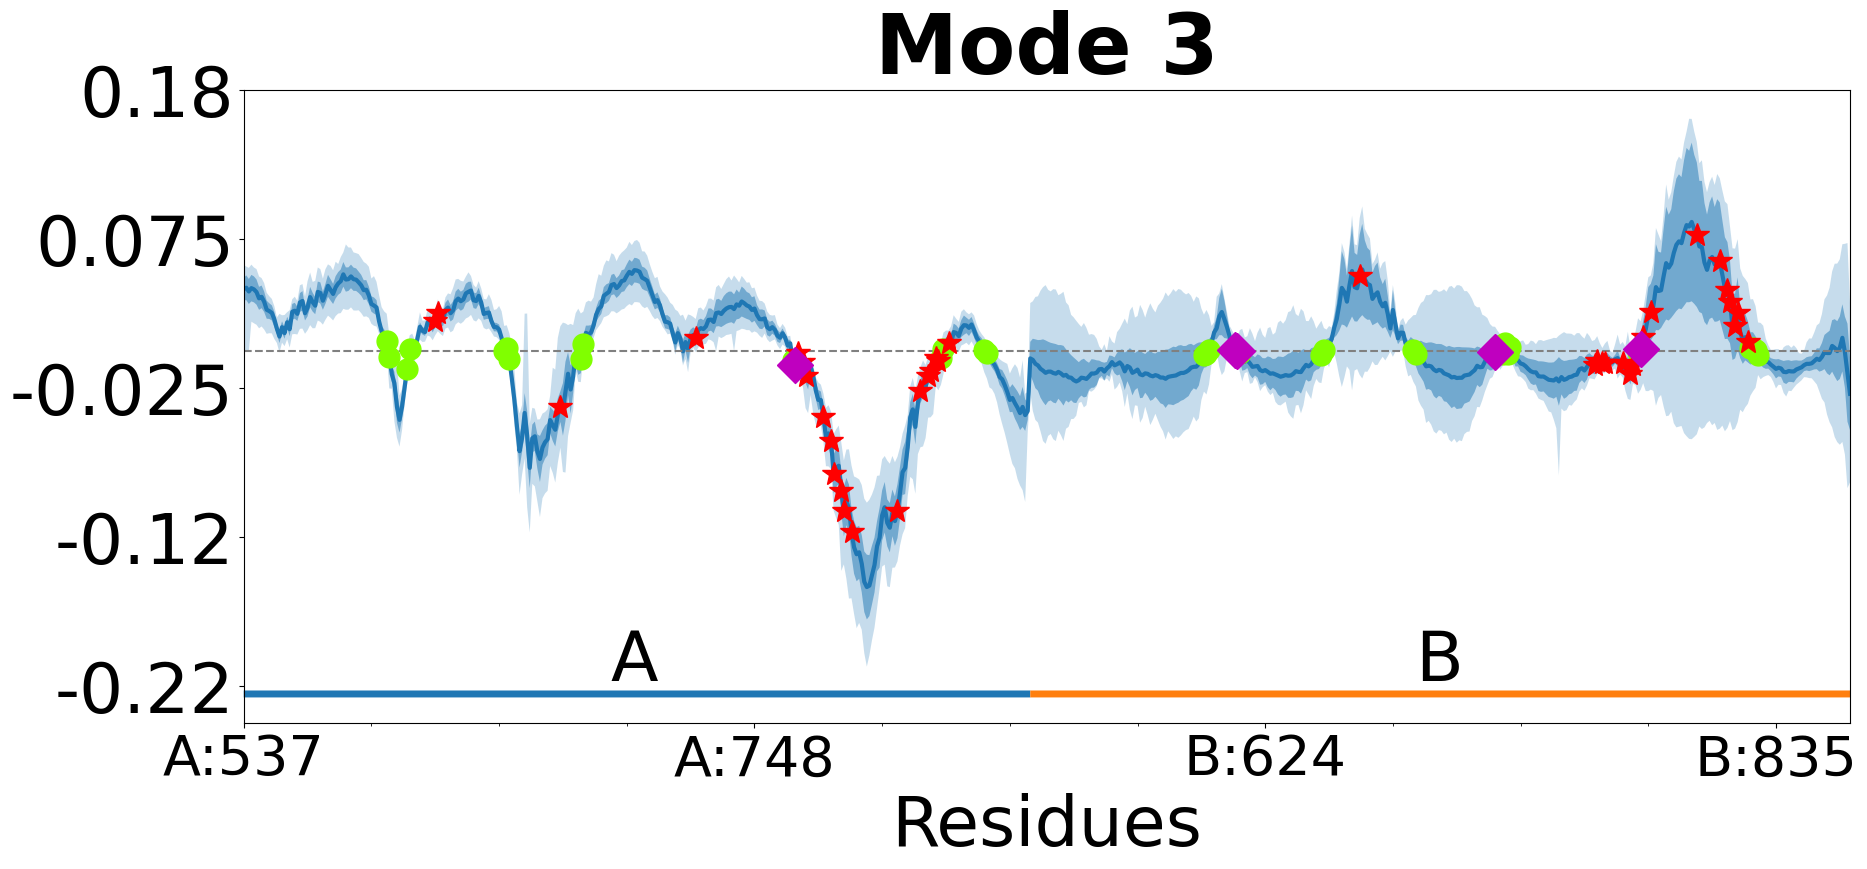

In [549]:
modes = 2 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

In [497]:
ORA(42, 626, 44, 8)

0.006010665702951723

# store data

In [254]:
mode = 2

In [255]:
residue = []
new_b_factor = []

for item in averageEigVecs[:, mode]:
    new_b_factor.append(item)


In [256]:
resiIndex = [x for x in range(537, 665)]
chain = ['A' for x in range(537, 665)]
resiIndex += [x for x in range(676, 861)]
chain += ['A' for x in range(676, 861)]

resiIndex += [x for x in range(537, 665)]
chain += ['B' for x in range(537, 666)]
resiIndex += [x for x in range(676, 861)]
chain += ['B' for x in range(676, 861)]

In [257]:
with open('./structure_demo/PDE5A_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
    for i in range(len(resiIndex)):
        # print (chain[i])
        wf.write(chain[i] + ', ' + str(resiIndex[i]) + ', ' + str(new_b_factor[i]) + '\n')